### <font face="Georgia">This term paper consists of four parts:</font>

- <font face="Georgia">**Data description**</font>
- <font face="Georgia">**Model specification**</font>
- <font face="Georgia">**MCMC analysis**</font>
- <font face="Georgia">**Sensitivity analysis**</font>

## <font face="Georgia">1. Data description</font>

In [77]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import math

In [140]:
data = pd.read_csv('abalone.csv')

<font face="Georgia">First, let's look at the data:</font>
<font face="Georgia"></font>
<font face="Georgia"></font>
<font face="Georgia"></font>

In [141]:
data[0:5]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [142]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


- <font face="Georgia">The total sample size is : 4177</font>
- <font face="Georgia">Variable names include: Sex, Length, Diameter, Height, Whole weight,	Shucked weight,	Viscera weight, Shell weight, Rings. </font>
    
    - <font face="Georgia">For Sex, it has **three** dummy M(male), F(male), and I (infant). Note that for young age abalone, it is very hard to distinguish its sex.  </font>
    
    - <font face="Georgia">For Rings, **plus 1.5 gives the age in years**</font>
    <br>
    <br>
      <font face="Georgia">Other variables include: </font>
    - <font face="Georgia">Length: longest shell measurement.</font>
    
    - <font face="Georgia">Diameter: perpendicular to length</font>
    
    - <font face="Georgia">Height: with meat in shell</font>
    
    - <font face="Georgia">Whole weight: whole abalone</font>
    
    - <font face="Georgia">Shucked weight: weight of meat</font>
    
    - <font face="Georgia">Viscera weight: gut weight (after bleeding)</font>
    
    - <font face="Georgia">Shell weight: after being dried</font>

<font face="Georgia">**To continue, I would like to slightly modify the original data to keep the analysis simple:**</font>  

- <font face="Georgia">I droped those Infant individuals, since we alreday have rings(age) on the left side of the model, we do not need another indicator of age on the right side.</font>

- <font face="Georgia">**I only keep representative variables: Sex,Shucked weight, Shell weight and Rings**. </font>

<font face="Georgia">**Remark:** I drop **Length,Diameter,Height** beacause after try and error with many combinations of those covariates, the coefficients of these three tend to have non-convergent chains and very little effect on predicting the age of abalone. A reason might be that in a linear regression model, an intercept may be enough to cover the effect of these three redundant factors. Similarly, **Whole weight** and **Viscera weight** also represent trivial effect compared with the other two measurements. </font>




In [234]:
abalone_data = data[data.Sex != 'I'].copy()
abalone_data = abalone_data.drop(columns=['Length','Diameter','Height','Whole weight','Viscera weight']).copy()

In [235]:
abalone_data[0:5]

,Sex,Shucked weight,Shell weight,Rings
0,M,0.2245,0.150,15
1,M,0.0995,0.070,7
2,F,0.2565,0.210,9
3,M,0.2155,0.155,10
6,F,0.2370,0.330,20


In [236]:
abalone_data.describe()

,Shucked weight,Shell weight,Rings
count,2835.000000,2835.000000,2835.000000
mean,0.439051,0.291208,10.900882
std,0.212193,0.128835,3.069252
min,0.006500,0.005000,3.000000
25%,0.287000,0.202500,9.000000
50%,0.431500,0.285000,10.000000
75%,0.568750,0.365000,12.000000
max,1.488000,1.005000,29.000000


<font face="Georgia">Now the sample size was reduced to 2835, we can start our analysis.</font>

## <font face="Georgia">2. Model specification</font>
<font face="Georgia"></font>
<font face="Georgia"></font>
<font face="Georgia"></font>

<font face="Georgia">Consider a linear model between the age(ring+1.5) and other physical measurements:</font>

- <font face="Georgia">$\operatorname{Age}_i (\operatorname{Rings}+1.5)=\beta_0 +\beta_1\operatorname{Sex}_i+\beta_2\operatorname{Shucked weight}_i+\beta_3\operatorname{Shell weight}_i+\varepsilon_i$</font>

<font face="Georgia">Let's impose some assumpitons on parameters and observations:</font>
<br>

<br>
<font face="Georgia">**Likelyhood**</font>

- <font face="Georgia">$\operatorname{Age}\sim\mathcal{N(\mu,\sigma^2)}$</font>
   
   - <font face="Georgia">$\mu=\beta_0 +\beta_1\operatorname{Sex}+\beta_2\operatorname{Shucked weight}+\beta_3\operatorname{Shell weight}$</font>

   
<font face="Georgia">**Priors**</font>
<br>
<br>
<font face="Georgia">For $(\sigma^2)^{-1}$ : </font>

1. <font face="Georgia">$(\sigma^2)^{-1}\sim \operatorname{Gamma}(0.0001,0.0001)$ (approximates the improper prior)</font> 
2. <font face="Georgia">A candidate selection for sensitivity check might be $(\sigma^2)^{-1}\sim \operatorname{Uniform}[0.00001,1]$</font>

<font face="Georgia">For $\beta$ : </font>

1. <font face="Georgia">We can assume Normal priors with mean $0$ and large variance for $\beta$ parameters.</font>
    
    - <font face="Georgia">$\beta_0\sim\mathcal{N}(0,10000)$</font>
    - <font face="Georgia">$\beta_1\sim\mathcal{N}(0,10000)$</font>
    - $\vdots$
    - <font face="Georgia">$\beta_3\sim\mathcal{N}(0,10000)$</font>
    <br>
2. <font face="Georgia">Or we can assume uniform distribution as a sensitivity check</font>
   
   - <font face="Georgia">$\beta_0\sim\operatorname{Uniform}[-50,50]$</font>
   - <font face="Georgia">$\beta_1\sim\operatorname{Uniform}[-50,50]$</font>
   - $\vdots$
   - <font face="Georgia">$\beta_3\sim\operatorname{Uniform}[-50,50]$</font>

<font face="Georgia">To start to write the model, I first do some data transformation: </font>

In [237]:
#Rings/Sex/Length/Diameter/Height/Whole weight
Age=[]
for i in abalone_data['Rings']:
     Age.append(i+1.5)

Sex=[] # Male for 0, female for 1
for i in abalone_data['Sex']:
    if i == 'M':
        Sex.append(0)
    else:
        Sex.append(1)

Shucked_W=[]
for i in abalone_data['Shucked weight']:
    Shucked_W.append(i)

Shell_W=[]
for i in abalone_data['Shell weight']:
    Shell_W.append(i)

<font face="Georgia">Then, we can write out model as followed:</font>

In [238]:
with pm.Model() as abalone_model:
    #Priors
    beta0=pm.Normal('Intercept', 0, sd=100)
    beta1=pm.Normal('Sex', 0, sd=100)
    beta2=pm.Normal('Shucked weight', 0, sd=100)
    beta3=pm.Normal('Shell weight', 0, sd=100)
    
    inv_sigma_square = pm.Gamma('inv_sigma_square',alpha=0.0001, beta=0.0001)
    sigma_square = 1/inv_sigma_square
    mu =beta0+beta1*np.array(Sex)+beta2*np.array(Shucked_W)+beta3*np.array(Shell_W)
    #Likelyhood
    Likelyhood = pm.Normal('Age', mu=mu,sd=sigma_square, observed=Age)
        

## <font face="Georgia">3. MCMC analysis</font>
<br>
<font face="Georgia">Let's run MCMC and simulated 5000 samples and 2 independent chains for each parameters :</font>

In [239]:
with abalone_model:
    abalone_trace = pm.sample(5000,chains=2,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [inv_sigma_square, Shell weight, Shucked weight, Sex, Intercept]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:40<00:00, 295.59draws/s]


<font face="Georgia">Then, I plot the trace and marginal posterior using the simulated observations.</font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c320d84e0>,
      dtype=object)

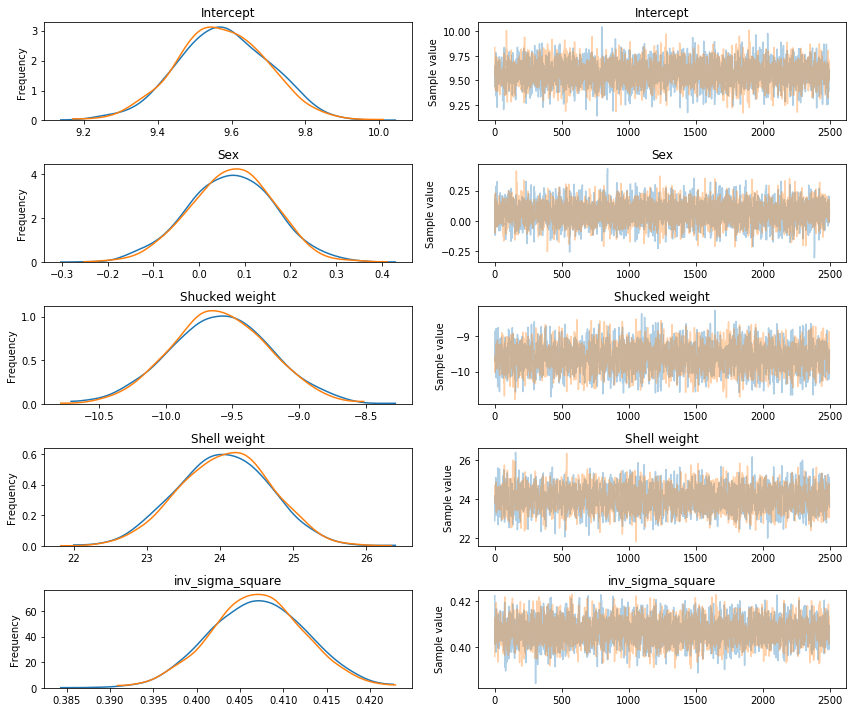

In [240]:
pm.traceplot(abalone_trace[2500:])

<font face="Georgia">As you see above, the left column is the marginal posterior densities, and the right column is the traceplot. **Notice that I just use the remaining simulated 2500 samples to plot (5000 in total, and I use the first half as burn-in period)**.  </font>
<br>
<br>
<font face="Georgia">From both the traceplot(low correlation within simulated samples) and the coincided two independent chains for each parameter, we can conclude that the Markov Chains converge.</font>
<br>
<br>
<font face="Georgia">In terms of the sample autocorrelation functions: </font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c305835c0>,
      dtype=object)

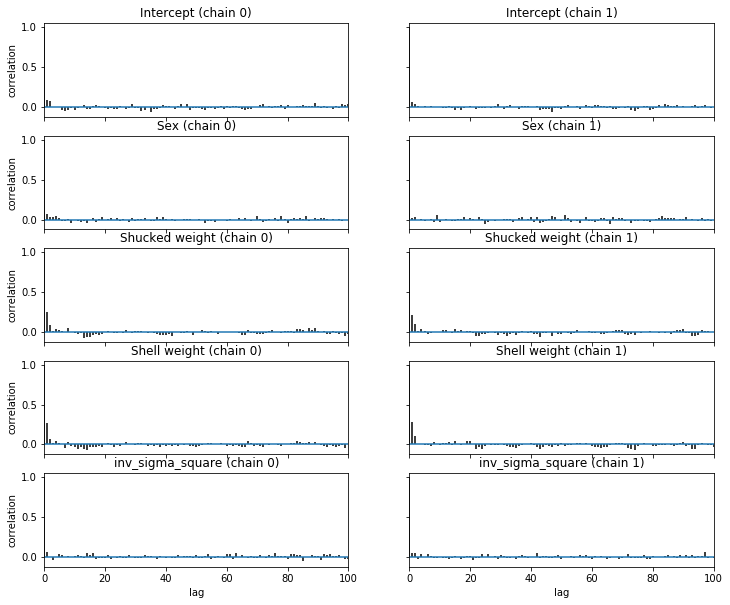

In [241]:
pm.autocorrplot(abalone_trace[2500:])

<font face="Georgia">As a result, we find that only the simulation of parameters are highly efficient</font>
<br>
<br>
<font face="Georgia">Posterior means, posterior standard deviations, and 95% credible intervals are summarized as followed:</font>

In [242]:
pm.summary(abalone_trace[2500:]).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,9.57,0.12,0.00,9.34,9.82,3857.85,1.0
Sex,0.07,0.09,0.00,-0.12,0.25,4065.88,1.0
Shucked weight,-9.59,0.37,0.01,-10.32,-8.86,2789.68,1.0
Shell weight,24.06,0.62,0.01,22.81,25.19,2744.61,1.0
inv_sigma_square,0.41,0.01,0.00,0.40,0.42,4480.35,1.0


<font face="Georgia">In terms of the marginal posterior distribution:</font>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c68a9eeb8>,
      dtype=object)

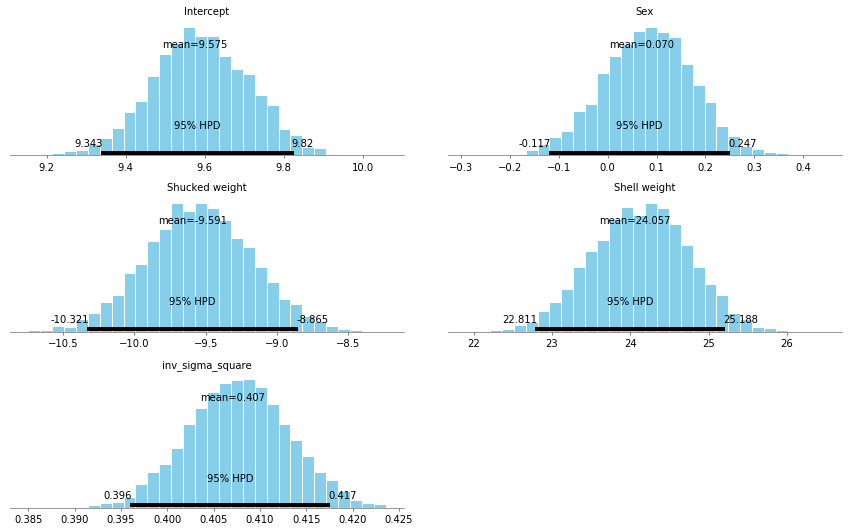

In [291]:
pm.plot_posterior(abalone_trace[2500:])

<font face="Georgia">From the summary of statistics, we may find that:</font>

- <font face="Georgia"> *Sex* seems have little to do about the abalone's age.</font>

- <font face="Georgia">Both *Shucked weight* and *Shell weight* are strong indicators of the ages of abalone.</font>
    
    - <font face="Georgia"> *Shucked weight* means the weight of meat. It seems that younger abalone tend to be stronger in muscle, it is very intuitive.

    - <font face="Georgia"> At the same time, *Shell weight* increases as the abalone ages. And the correlation is the strongest.
    
<font face="Georgia">As a result, a conclusion might be that, as the abalone ages, it tends to have thicker shell (may be to protect themselves) and less fresh.</font> 

## <font face="Georgia">4. Sensitivity check</font>
<font face="Georgia">Suppose instead of normal priors and gamma priors, we use uniform distribution, it turns out that the result stays the same: **nothing changes, the result is robust**.</font>
<br>
<font face="Georgia"> The code and result are as followed:<font face="Georgia">

In [279]:
with pm.Model() as another_model:
    #Priors
    beta0=pm.Uniform('Intercept', lower=-50, upper=50)
    beta1=pm.Uniform('Sex', lower=-50, upper=50)
    beta2=pm.Uniform('Shucked_W', lower=-50, upper=50)
    beta3=pm.Uniform('Shell_W', lower=-50, upper=50)
    
    inv_sigma_square = pm.Uniform('inv_sigma_square', lower=0.0001,upper=1)
    sigma_square = 1/inv_sigma_square
    mu =beta0+beta1*np.array(Sex)+beta2*np.array(Shucked_W)+beta3*np.array(Shell_W)
    #Likelyhood
    Likelyhood = pm.Normal('Age', mu=mu,sd=sigma_square, observed=Age)

In [281]:
with another_model:
    another_trace = pm.sample(5000,chains=2,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [inv_sigma_square, Shell_W, Shucked_W, Sex, Intercept]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:39<00:00, 350.16draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c644fd358>,
      dtype=object)

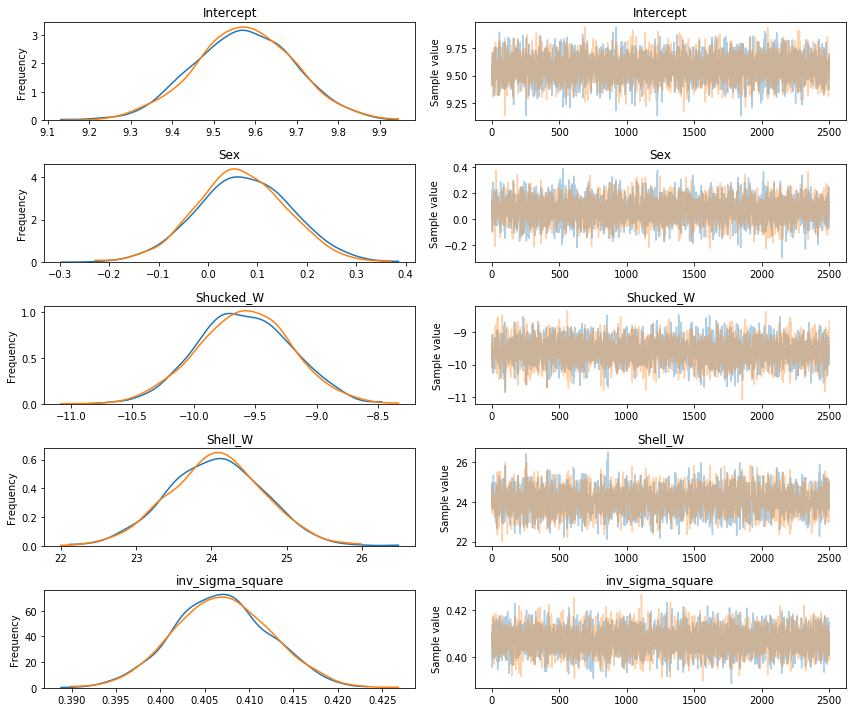

In [282]:
pm.traceplot(another_trace[2500:])

In [283]:
pm.summary(another_trace[2500:]).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,9.57,0.12,0.00,9.33,9.80,4772.20,1.0
Sex,0.07,0.09,0.00,-0.11,0.25,4952.63,1.0
Shucked_W,-9.59,0.38,0.01,-10.31,-8.83,2938.40,1.0
Shell_W,24.07,0.63,0.01,22.85,25.29,2988.48,1.0
inv_sigma_square,0.41,0.01,0.00,0.40,0.42,4762.20,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c675980b8>,
      dtype=object)

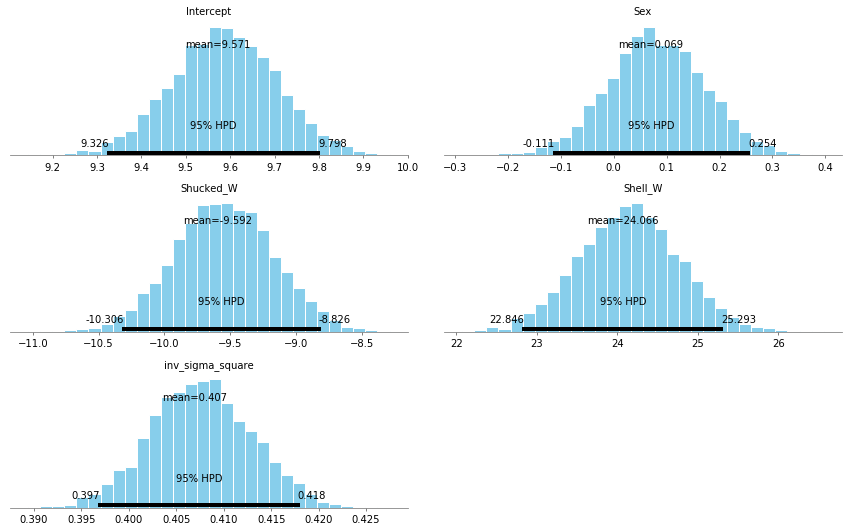

In [288]:
pm.plot_posterior(another_trace[2500:])